# Imports

In [275]:
# Imports
import numpy as np
import pandas as pd
import pyspark
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import contractions
import math
from itertools import chain
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
from nltk.stem import WordNetLemmatizer

import re
import string
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from google.cloud import bigquery

from sklearn.feature_extraction.text import TfidfVectorizer 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [276]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

client = bigquery.Client(location="US", project="helio-staging")

Client creating using default project: helio-staging


# Constants + Functions

In [277]:
GROUP_CUSTOM_STOPWORDS = [
    "bike", "nbsp", "crn","sample", "bikes", "great", "good", "love","like", "recommend","smells","collected","part","review","promotion","razor",
    "shave","shaving","blade","camille","cantu","daughter","today","kccc","jessie","miss","fabric","pillow","softener","or",    "tiktok","OR",
     'Proov', 'proov','Natalist', 'natalist','Stix', 'stix','Clear Blue', 'blue','Modern Fertility', 'modern', 'free', 'app', 'mf', 'android', 'pinchme',
    'Pregmate', 'pregmate', 'received','First Response', 'test', 'ovulation', 'none', 'see', 'store', 'day', 'month', 'amy', 'face', 'far', 'scan',
    'it‚äôs','don‚äôt', 'using_minoxidil', '_oz','i‚äôm','moreread','using','stating',
    'doesn‚äôt', 'classic','order','ordering', 'best', 'hard', 'seltzer', 'claw','never','got','ordered','white','product','high-noon','bottle','girl',
    'read_lessread','read_moreread','lessread_le','le_stating','moreread_stating','scalp detox','le_serum',
    'moreread_serum','i’ve_stem','hair_read','don’t_know','i’ve_bought', 'liquid_kinda', "i'ḿ"'use_serum','le_mus','read_serum','ingredient_us','oz_extreme',
    'cell_serum','cell','stem','le','read','lessread','moreread','more','multi-colored—from_brown','findin_read','strengthening_hair','hair_oil','care_oil',
    'hair','oil_hair','extreme_hair','hair_care','extreme','oz','_strengthening','used twice', 'oil_oil', 'customer',    'nan', 'read_moreread', 'noreferrer',
    'noreferrer_farmer','farmer_dog/a','noreferrer_ollie/a','rel','noopener','blank_rel',
    'rel_nofollow','blank','nofollow','target_blank','noopener_noreferrer','nofollower_noopener','nofollow_noopener',"partake","partake_cooky", "crunchy_cooky","cooky_vegan","madegood","apple_jack"
]

added_stopwords_li = [
    "it’s",    "'d",    "'s",
    "n't",    "'m",
    "i've",    "it's",    "'ve",
    "'re",    "'ll",    "``",    "''",    "...",    "--", "https",
    "voxbox",    "influenster",    "cracker",    "or",    'it‚äôs',
    'don‚äôt',    'i‚äôm',    'doesn‚äôt',    "get", "also",    "even",    "since", "amy"
]

REV_COLS = ['source_name',
    'normalized_url',
    'review_source_id',
    'reviewer_source_id',
    'brand_name',
    'product_name',
    'product_source_id',
    'review_date',
    'review_rating',
    'review_content'
]

product_categories = ['Accessories',
'Alcoholic Beverages',
'Apparel & Footwear',
'Food',
'Food Establishments',
'Health & Beauty Establishments',
'Household Consumables',
'Household Durables',
'Other',
'Pet Products',
'Non-Alcoholic Beverages',
'Personal Care & Beauty',
'Retailers',
'Sports & Outdoors'
]

drop_words = ["kinship",
              "mineral",
              "trendmood",
              "hue_stick",
              "huesticks",
              "stick",
              "blume",
              "daydreamer",
              "loli",
              "plum",
              "elixir",
              "nut",
              "beekman",
              "goat",
              "milk",
              "bloom",
              "fifth_root",
              "fifth",
              "lip",
              "cannuka",
              "review",
              "zitsticka",
              "discipline",
              "uoma",
              "bv",
              "yeast",
              "bye_bloat",
              "tula",
              "tula_product",
              "huestick",
              "hue",
              "live_tinted",
              "meltdown",
              "loli_product",
              "bloom_cream",
              "beekman_product",
              "pure_goat",
              "karmic_cleanse",
              
             ]

MIN_TERM_PCT = 0

MAX_TERM_PCT = 100

TERM_PERCENT_HEAD = 1

TOP_N_WORDS = 8

np.random.seed(42) # set seed for models for reproducibility

stopwords_li = stopwords.words('english')
punkts_li = list(string.punctuation)

REVIEWS_PER_BRAND_TO_ANALYZE = 10_000

In [278]:
def tokenize(s, strip_str="=-_/\+.:,'* 1234567890—"):
    custom_words_li = GROUP_CUSTOM_STOPWORDS + added_stopwords_li+stopwords_li + punkts_li + [""]
    return [w.lower().strip(strip_str) for w in word_tokenize(str(s)) if w.lower().strip(strip_str) not in custom_words_li]

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokens]

def unique_list(li):
    deduped_li = list(set(li))
    return deduped_li

def bigram(tokens):
    bi_tup = list(bigrams(tokens))
    bi_li = ['_'.join(tup) for tup in bi_tup]
    return bi_li


# Load Data

In [279]:
GROUP_NAME = "Skincare"
# GROUP_NAME = 'Meat Substitutes'


# When using Streamlit, leave list empty and un-comment cells below

#Cereals
NORMALIZED_URL_LI = [
    "lovekinship.com",
    "livetinted.com",
    "blume.com",
    "lolibeauty.com",
    "beekman1802.com",
    "fifthandroot.com",
    "theroutebeauty.com",
    "cannuka.com",
    "zitsticka.com",
    "uomabeauty.com",
    "lovewellness.com",
    "tula.com"
]

PRIMARY_CATEGORIES = [
    'Skincare',
]                      


BRAND_NAME_LI = [
    "Kinship",
    "Live Tinted",
    "Blume",
    "LOLI Beauty",
    "Beekman 1802",
    "fith & root",
    "The Route",
    "Cannuka",
    "ZitSticka",
    "Uoma Beauty",
    "Love Wellness",
    "Tula Skincare"
]

retailer = ["ulta", "credo"]
brand_name_di = dict(zip(NORMALIZED_URL_LI, BRAND_NAME_LI))

external_revs_list = []



    
PROD_CAT_EXCLUDE_LI = ['Pet Products']
    
PRODUCT_NAME_NOT_CONTAINS_LI = ['toothpaste']


In [280]:
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
        bigquery.ArrayQueryParameter("cols", "STRING", REV_COLS),
        bigquery.ArrayQueryParameter("brands", "STRING", BRAND_NAME_LI)
    ]
)

In [281]:
job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI)
        ]
)
max_date_query = """
    SELECT max(execution_date)
    FROM `helio-staging.online_reviews.online_reviews__deduped_review__1_0`
    where execution_date > DATE_ADD(current_date(), INTERVAL -10 DAY)
    and normalized_url IS NOT NULL
    """
query_job = client.query(
    max_date_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

max_date = query_job.to_dataframe()['f0_'].astype('str')[0]


In [282]:
max_date

'2022-03-14'

In [283]:
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
        bigquery.ScalarQueryParameter("max_date", "STRING", max_date),
        bigquery.ArrayQueryParameter("retailers", "STRING", retailer)

    ]
)
review_query = """
    SELECT source_name,
    normalized_url,
    review_source_id,
    reviewer_source_id,
    product_name,
    product_source_id,
    review_date,
    review_rating,
    review_content
    FROM `helio-staging.online_reviews.online_reviews__deduped_review__1_0`
    WHERE normalized_url IN UNNEST (@url)
    AND source_name IN UNNEST (@retailers)
    AND execution_date = @max_date
    """
query_job = client.query(
    review_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

reviews = query_job.to_dataframe()
reviews = reviews.loc[reviews.astype(str).drop_duplicates().index]


In [284]:
reviews = reviews[reviews["source_name"]=="ulta"]

In [285]:
#reviews.shape

In [286]:
reviews.groupby("normalized_url").count()

,source_name,review_source_id,reviewer_source_id,product_name,product_source_id,review_date,review_rating,review_content
normalized_url,,,,,,,,
beekman1802.com,6502,6502,6502,6502,6502,6502,6502,6502
blume.com,4111,4111,4111,4111,4111,4111,4111,4111
cannuka.com,401,401,401,401,401,401,401,401
fifthandroot.com,473,473,473,473,473,473,473,473
livetinted.com,2257,2257,2257,2257,2257,2257,2257,2257
lolibeauty.com,893,893,893,893,893,893,893,893
lovekinship.com,1432,1432,1432,1432,1432,1432,1432,1432
lovewellness.com,22132,22132,22132,22132,22132,22132,22132,22132
tula.com,33989,33989,33989,33989,33989,33989,33989,33989


In [287]:
# Product Category Data

query = """
    SELECT product_source_id, parent_category, primary_category
    FROM `helio-staging.taxonomy.product_taxonomy__1_0`
    WHERE normalized_url IN UNNEST (@url)

    """
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

prod_cat = query_job.to_dataframe()

In [230]:
# All primary categories

query = """
    SELECT distinct parent_category
    FROM `helio-staging.taxonomy.product_taxonomy__1_0`
    """
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

cat_list = query_job.to_dataframe()

In [231]:
# Join reviews with product categories

reviews = pd.merge(
    reviews, 
    prod_cat, 
    on='product_source_id', how='left').drop_duplicates(subset=['source_name', 'review_source_id'])

# Filter out excluded categories, excluded product name terms
PROD_CAT_EXCLUDE_LI = ['Pet Products']

for term in PROD_CAT_EXCLUDE_LI:
    reviews = reviews[(~reviews['parent_category'].fillna('').str.contains(term))]

    
PRODUCT_NAME_NOT_CONTAINS_LI = ['Purina', 'Krill']
for term in PRODUCT_NAME_NOT_CONTAINS_LI:
    reviews = reviews[~(reviews['product_name'].str.lower().fillna('').str.contains(term.lower()))]

In [288]:
# Get most recent n reviews

reviews = (reviews
           .sort_values('review_date',ascending = False)
           .groupby('normalized_url')
           .head(REVIEWS_PER_BRAND_TO_ANALYZE)
          )

reviews_count = reviews.groupby('normalized_url').agg({'review_source_id':'count'}).reset_index().rename(columns={"review_source_id": "rev_count"})

reviews = pd.merge(reviews_count, reviews, on=['normalized_url'])

reviews = reviews[reviews['primary_category'].str.contains('|'.join(PRIMARY_CATEGORIES), na=False)]

KeyError: 'primary_category'

In [ ]:
reviews_count

In [234]:
#reviews = reviews[~reviews['product_name'].str.contains("REESE'S|TWIZZLERS|HERSHEY'S|Reese's|Reeses|ALMOND JOY|Mounds|Reese’s|Laeta|Kisses|Reese'S|Hershey")]



In [235]:
#reviews.to_csv("JOJO comps reviews 2022 02 22.csv")

In [289]:
tokenized_reviews = reviews.copy()
tokenized_reviews['tokenized_review'] = tokenized_reviews['review_content'].apply(lambda x: lemmatize(tokenize(x)))
tokenized_reviews = tokenized_reviews.dropna(subset=['tokenized_review'])

In [304]:
unibi_reviews = tokenized_reviews.copy()

unibi_reviews['unibi'] = unibi_reviews['tokenized_review'].apply(lambda x: unique_list(bigram(x)+x))
unibi_reviews = unibi_reviews.loc[unibi_reviews.astype(str).drop_duplicates().index]

unibi_words = unibi_reviews.copy()
unibi_words['unibi_word'] = unibi_words['unibi']
unibi_words = unibi_words.explode('unibi_word')
unibi_words = unibi_words[~unibi_words["unibi_word"].isin(drop_words)]
#unibi_words=unibi_words[unibi_words["parent_category"]=="Food"]

In [291]:
grouped_sdf = pd.DataFrame(unibi_reviews.groupby('normalized_url').unibi.apply(sum)).reset_index()

In [292]:
pd.set_option('max_colwidth', 50)

#tokenized_reviews[(tokenized_reviews['review_source_id']=='232203656')]

grouped_sdf['unibi_str'] = [','.join(map(str, l)) for l in grouped_sdf['unibi']]

In [293]:
grouped_sdf

,normalized_url,unibi,unibi_str
0,beekman1802.com,"[soft, finally_found, fortune_rodan, found_org...","soft,finally_found,fortune_rodan,found_organic..."
1,blume.com,"[acne, give_moisturized, acne_scar, morning, a...","acne,give_moisturized,acne_scar,morning,acne_r..."
2,cannuka.com,"[moisturizing_wake, hoping, would_hydrating, e...","moisturizing_wake,hoping,would_hydrating,eye_c..."
3,fifthandroot.com,"[odd, deeply, odd_smell, drier, start, tlc, ne...","odd,deeply,odd_smell,drier,start,tlc,need,smel..."
4,livetinted.com,"[peachy, work_beautifully, dark_age, excellent...","peachy,work_beautifully,dark_age,excellent_pac..."
5,lolibeauty.com,"[daily, looking_oil, little, fragrance, need_l...","daily,looking_oil,little,fragrance,need_little..."
6,lovekinship.com,"[long, last_especially, especially_use, overpo...","long,last_especially,especially_use,overpoweri..."
7,lovewellness.com,"[cleared, cleared_bv, bv, infection_instead, g...","cleared,cleared_bv,bv,infection_instead,gave,b..."
8,tula.com,"[right, damp, say_make, claim_dry, watched_mak...","right,damp,say_make,claim_dry,watched_make,dam..."
9,uomabeauty.com,"[wish, everyday, would_purchased, wear_especia...","wish,everyday,would_purchased,wear_especially,..."


In [302]:
frames = []

for i in range(len(grouped_sdf)):    
# settings that you use for count vectorizer will go here 
    tfidf_vectorizer=TfidfVectorizer(
        norm=None,
        sublinear_tf=False,
        use_idf=True,
        lowercase=False,
        stop_words='english',
        smooth_idf=True,
        max_df = len(grouped_sdf['normalized_url'])-1
    ) 

    # just send in all your docs here 
    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(grouped_sdf['unibi_str'])

    # get the first vector out (for the first document) 
    first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[i]

    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
    joined_df = unibi_words[(unibi_words['normalized_url']==grouped_sdf.reset_index()['normalized_url'][i])].join(df, on='unibi_word', how='inner', lsuffix='_left', rsuffix='_right')
    frames.append(joined_df)

df = pd.concat(frames)
#reviews = unibi_reviews[(unibi_reviews['normalized_url'] == url)]
#joined_df = unibi_reviews.join(df, on='unibi_word', how='inner', lsuffix='_left', rsuffix='_right')
sorted_df = df[['normalized_url', 'unibi_word', 'tfidf']].sort_values(by=['normalized_url', "tfidf"],ascending=False).drop_duplicates()


In [303]:
sorted_df

,normalized_url,unibi_word,tfidf
36706,zitsticka.com,skin_discipline,2445.581295
36615,zitsticka.com,zit,2194.388809
36607,zitsticka.com,cystic,2171.924700
36607,zitsticka.com,cystic_acne,1397.504080
36627,zitsticka.com,hormonal,1189.818235
...,...,...,...
4205,beekman1802.com,get_rid,1.182322
1059,beekman1802.com,tool,1.087011
2542,beekman1802.com,possibly,1.087011
2742,beekman1802.com,swear,1.087011


In [295]:
tf_idf_output = sorted_df.groupby('normalized_url').head(TOP_N_WORDS)

In [296]:
unibi_reviews_grouped = unibi_words.groupby(['normalized_url', 'unibi_word']).agg({'review_rating':'mean', 'review_source_id':'count'})

unibi_reviews_grouped = unibi_reviews_grouped.rename(columns={"review_rating": "avg_rating", "review_source_id": "review_count"})

In [297]:
avg_rating_tfidf = pd.merge(unibi_reviews_grouped, tf_idf_output, on=['normalized_url', 'unibi_word'], how='inner').sort_values(by=['normalized_url', "tfidf"],ascending=False)[['normalized_url','unibi_word', 'tfidf', 'avg_rating']]

In [298]:
avg_rating_tfidf["normalized_url"].unique()

array(['zitsticka.com', 'uomabeauty.com', 'tula.com', 'lovewellness.com',
       'lovekinship.com', 'lolibeauty.com', 'livetinted.com',
       'fifthandroot.com', 'cannuka.com', 'blume.com', 'beekman1802.com'],
      dtype=object)

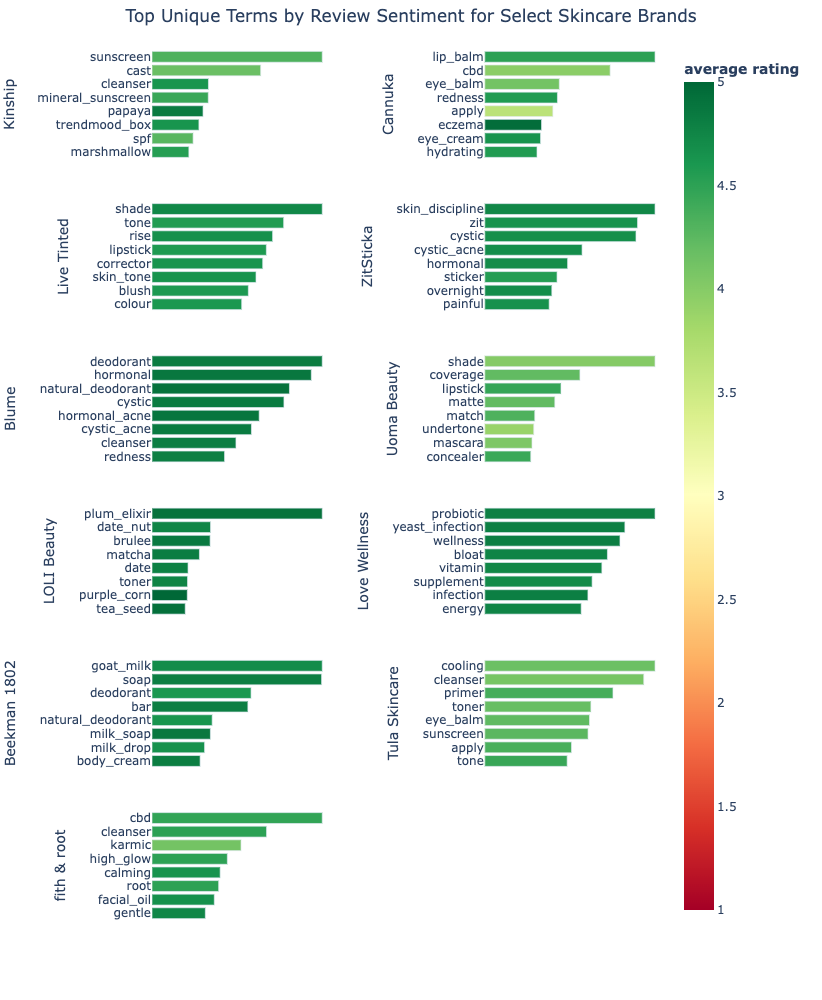

In [299]:
avg_rating_tfidf['normalized_url_cat'] = pd.Categorical(
    avg_rating_tfidf['normalized_url'], 
    categories=NORMALIZED_URL_LI, 
    ordered=True
)

n_brands = len(grouped_sdf['normalized_url'])

fig = make_subplots(
    rows=math.ceil(n_brands/2),
    cols=2,
    horizontal_spacing = 0.3
)

# Loop through
# If j is greater than (number of brands/2)-1, then the graph will be shown in the second column
j = 0

for url, data in avg_rating_tfidf.sort_values(['normalized_url_cat', 'tfidf']).groupby('normalized_url', sort = False):
    if j <= math.ceil(n_brands/2)-1:
        fig.add_trace(
            go.Bar(
                orientation='h',
                x=data.tfidf,
                y=data.unibi_word,
                marker=dict(color=data.avg_rating, coloraxis="coloraxis")
                
            ),
            row=j+1, col=1
        )
        j += 1
        fig.update_yaxes(automargin = True,title_text=brand_name_di.get(url), row=j, col=1, dtick =.3)#use dtick if not all term labels show up 
        fig.update_xaxes(automargin = True,showticklabels=False)
        
    else:
        fig.add_trace(
            go.Bar(
                orientation='h',
                x=data.tfidf,
                y=data.unibi_word,
                marker=dict(color=data.avg_rating, coloraxis="coloraxis")
            ),
            row=j-math.ceil(n_brands/2)+1, col=2
        )
        j += 1
        fig.update_yaxes(automargin = True,title_text=brand_name_di.get(url), row=j-round(n_brands/2), col=2, dtick =.3)#use dtick if not all term labels show up 
        fig.update_xaxes(automargin = True,showticklabels=False)

  
    
fig.update_layout(
    autosize = True,
    width=1000,
    height=1000,
    margin=dict(t=50),
    plot_bgcolor="white",
    title={"y": 0.99, "x": 0.5, 'xanchor': 'center', 'yanchor': 'top'},
    coloraxis=dict(colorscale='RdYlGn', colorbar_title_text='<b>average rating</b>'),
    title_text=f"Top Unique Terms by Review Sentiment for Select {GROUP_NAME} Brands",
    showlegend=False,
    font=dict(
        size=12,
    ),
)


# Change width,height,margin for the layout of the chart
#fig.update_yaxes(title_text="Gardein", row=2, col=2)
#fig.update_yaxes(title_text="Beyond Meat", row=1, col=2)
fig.update_coloraxes(cmin=1,cmax=5)
fig.show()

In [300]:
grouped_sdf['normalized_url']

0      beekman1802.com
1            blume.com
2          cannuka.com
3     fifthandroot.com
4       livetinted.com
5       lolibeauty.com
6      lovekinship.com
7     lovewellness.com
8             tula.com
9       uomabeauty.com
10       zitsticka.com
Name: normalized_url, dtype: object

In [301]:
reviews.groupby('parent_category').agg({'review_source_id':'count'})

KeyError: 'parent_category'

In [ ]:
reviews_dist = reviews.groupby("normalized_url")["review_rating"].value_counts(normalize = True).reset_index(name = "percent_reviews").sort_values(["review_rating","normalized_url"])
brands = dict(zip(NORMALIZED_URL_LI,BRAND_NAME_LI))

reviews_dist["brand"] = reviews_dist["normalized_url"].map(brands)

fig = px.bar(reviews_dist, 
                   color="review_rating",
                   x = "percent_reviews",
                   y="brand", color_continuous_scale='RdYlGn',
                   orientation='h', 
                   barmode="stack",
                   width=800, height=600,
                   title = "Review Rating Distribution"
                   )


fig.update_layout(
    plot_bgcolor= 'rgba(0, 0, 0, 0)',
    paper_bgcolor= 'rgba(0, 0, 0, 0)',
    xaxis_title="% of total reviews",
    yaxis_title=" ",
    coloraxis_colorbar=dict(
        title="Rating",
    ),
    font=dict(
        size=16,
    ),
    xaxis=dict(tickformat=".0%")
)
fig.show()

In [ ]:
reviews.groupby('parent_category').agg({'review_source_id':'count'})